# Wind Turbine Stability Prediction

In this lecture, we will tackle a regression problem based on a wind turbine data set from Kaggle. We try to predict the grid stability, which is given as a real number. This problem has beeen studied in the following paper:

Arzamasov, Vadim, Klemens Böhm, and Patrick Jochem. 'Towards Concise Models of Grid Stability.' Communications, Control, and Computing Technologies for Smart Grids (SmartGridComm), 2018 IEEE International Conference on. IEEE, 2018
(Section V-A)

Let us load and observe the data set.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
import numpy as np

df = pd.read_csv('smart_grid_stability_augmented.csv')

print(df.head())

       tau1      tau2      tau3      tau4        p1        p2        p3  \
0  2.959060  3.079885  8.381025  9.780754  3.763085 -0.782604 -1.257395   
1  9.304097  4.902524  3.047541  1.369357  5.067812 -1.940058 -1.872742   
2  8.971707  8.848428  3.046479  1.214518  3.405158 -1.207456 -1.277210   
3  0.716415  7.669600  4.486641  2.340563  3.963791 -1.027473 -1.938944   
4  3.134112  7.608772  4.943759  9.857573  3.525811 -1.125531 -1.845975   

         p4        g1        g2        g3        g4      stab     stabf  
0 -1.723086  0.650456  0.859578  0.887445  0.958034  0.055347  unstable  
1 -1.255012  0.413441  0.862414  0.562139  0.781760 -0.005957    stable  
2 -0.920492  0.163041  0.766689  0.839444  0.109853  0.003471  unstable  
3 -0.997374  0.446209  0.976744  0.929381  0.362718  0.028871  unstable  
4 -0.554305  0.797110  0.455450  0.656947  0.820923  0.049860  unstable  


The data set contains the following features:

* tau1: Reaction time (the delay between a price change and adaptation to it)- Energy producer
* tau2: Reaction time - Consumer 1
* tau3: Reaction time - Consumer 2
* tau4: Reaction time - Consumer 3
* p1: Power balance (power produced/consumed)- Energy producer
* p2: Power balance - Consumer 1
* p3: Power balance - Consumer 2
* p4: Power balance - Consumer 3
* g1: Price elasticity coefficient (gamma) - Energy producer
* g2: Price elasticity coefficient (gamma) - Consumer 1
* g3: Price elasticity coefficient (gamma) - Consumer 2
* g4: Price elasticity coefficient (gamma) - Consumer 3
* stab: Stability (continuous label)
* stabf: Stability status (binary label)


Reaction time means the delay between a price change and adaptation to it.
We have to drop `stabf` to create a regression problem. If `stab` is smaller than 0, then the grid is stable, otherwise it is unstable.

<AxesSubplot:xlabel='stabf', ylabel='stab'>

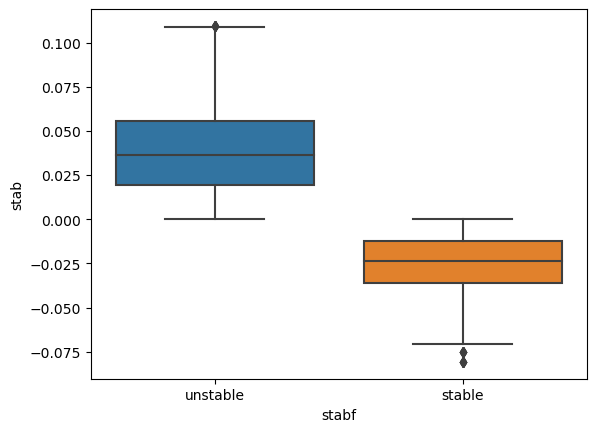

In [2]:
sns.boxplot(data = df, x = 'stabf', y = 'stab')

We drop the `stabf` column. We also separate the label from the features and split the data set.

In [3]:
df.drop('stabf', axis=1, inplace = True)

y = df.stab

df = df.iloc[:,:-1]

df_train, df_test, y_train, y_test = train_test_split(df, y, train_size= 0.95)

df_train = pd.DataFrame(df_train, columns= df.columns)
df_test = pd.DataFrame(df_test, columns= df.columns)
y_train = pd.DataFrame(y_train, columns= ['stab'])
y_test = pd.DataFrame(y_test, columns= ['stab'])

Let us see if there is any missing values in the data set and how the features are distributed.

In [4]:
print(df_train.isna().sum())
print(df_train.describe())

tau1    0
tau2    0
tau3    0
tau4    0
p1      0
p2      0
p3      0
p4      0
g1      0
g2      0
g3      0
g4      0
dtype: int64
               tau1          tau2          tau3          tau4            p1  \
count  57000.000000  57000.000000  57000.000000  57000.000000  57000.000000   
mean       5.251355      5.251769      5.249945      5.248621      3.749313   
std        2.739740      2.743051      2.743481      2.742510      0.752233   
min        0.500793      0.500141      0.500141      0.500141      1.582590   
25%        2.880615      2.873776      2.873564      2.874930      3.218268   
50%        5.250540      5.252816      5.249826      5.249892      3.750530   
75%        7.623733      7.628681      7.627239      7.623306      4.281664   
max        9.999469      9.999837      9.999837      9.999837      5.864418   

                 p2            p3            p4            g1            g2  \
count  57000.000000  57000.000000  57000.000000  57000.000000  57000.000000 

So far we did not have any issues with the data set. Let us see whether the variables are correlated with each other.

<AxesSubplot:>

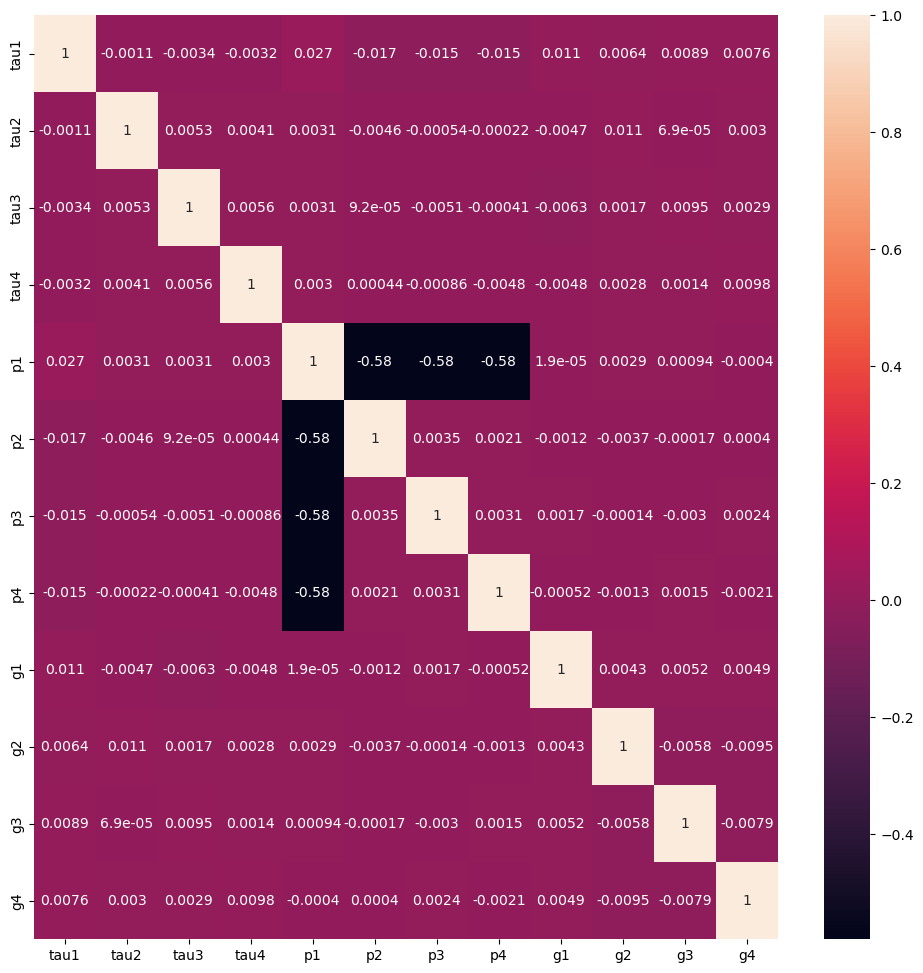

In [5]:
plt.figure(figsize = (12,12))
sns.heatmap(df_train.corr(), annot=True)

So, the columns `p1` is negatively correlated with `p2`, `p3`, and `p4`. These correspond to power produced (`p1`) and consumed. This can be an issue if we are trying to infer the effects of these variables on the label. In terms of prediction, this is not a huge problem but still you have to be aware that the coefficients may be affected by the correlation.

We can now run a linear regression model using Scikit-Learn and see how this performs on the test data.

In [6]:
lr = LinearRegression(fit_intercept= True)

lr.fit(df_train, y_train)

yhat = lr.predict(df_test)

To see the performance of the model we will use three metrics:
* Mean absolute error: This shows how far the predictions are from the real values.
* Mean squared error: This considers the square of the distances between the predictions and real values.
* Mean absolute percentage error: This is the MAE in terms of percentage.

In [7]:
print('MAE: ', mean_absolute_error(y_test, yhat))
print('MSE: ',mean_squared_error(y_test, yhat))
print('MAPE: ',mean_absolute_percentage_error(y_test, yhat))

MAE:  0.01724716269734065
MSE:  0.0004770735712721758
MAPE:  3.534733287461283


Of course the number by themselves are not very meaningful for comparison. Let us see how we can visualize error to get a better idea. We will first use a scatter plot of actual and predicted values.

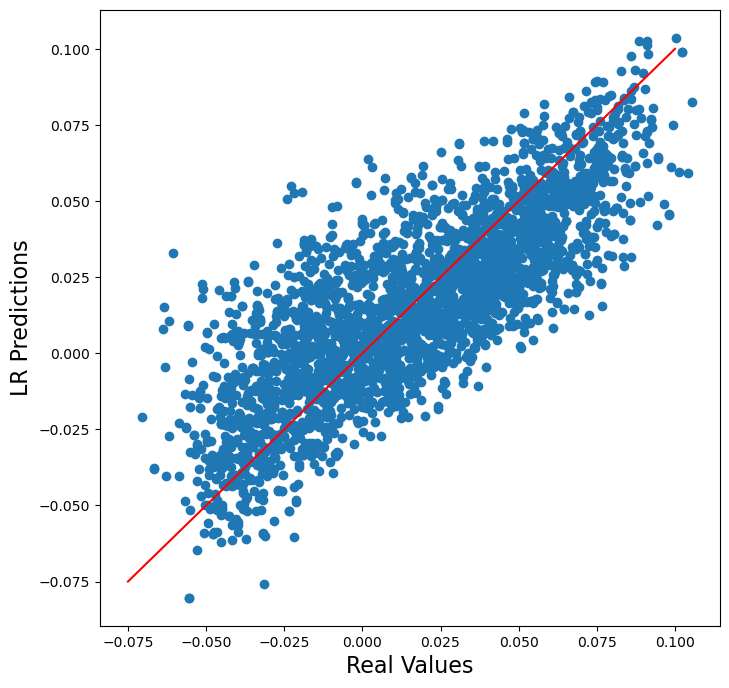

In [8]:
plt.figure(figsize = (8,8))
plt.scatter(y_test, yhat)
plt.plot([-0.075,0.1], [-0.075,0.1], c='r')
plt.ylabel('LR Predictions', fontsize = 16)
plt.xlabel('Real Values', fontsize = 16)
plt.show()

The results look ok, but it looks like there may be a systematic error the model is making. Let us draw the histogram of the residuals (error terms).




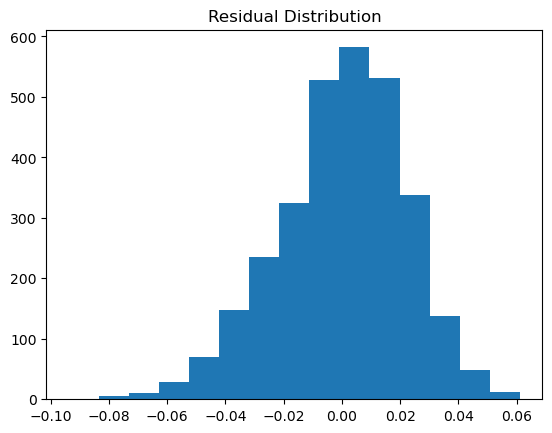

In [9]:
plt.hist(y_test - yhat, bins = 15)
plt.title('Residual Distribution')
plt.show()

The residuals are distributed more or less normally, even though the mean is not equal to 0. This is our first warning sign. To get a better feel we will plot the actual values and the error term as a scatter plot.

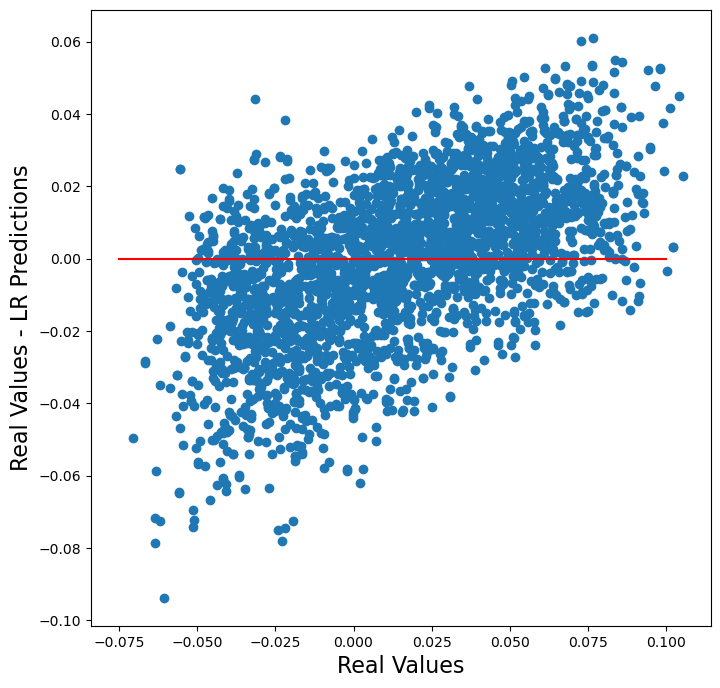

In [10]:
plt.figure(figsize = (8,8))
plt.scatter(y_test, y_test-yhat)
plt.plot([-0.075,0.1], [0,0], c='r')
plt.ylabel('Real Values - LR Predictions', fontsize = 16)
plt.xlabel('Real Values', fontsize = 16)
plt.show()

What does that figure say to us? When the real values increase the error term tends to increase as well. We can also do the same with the absolute error to see whether the magnitude of the error changes with the real values. 

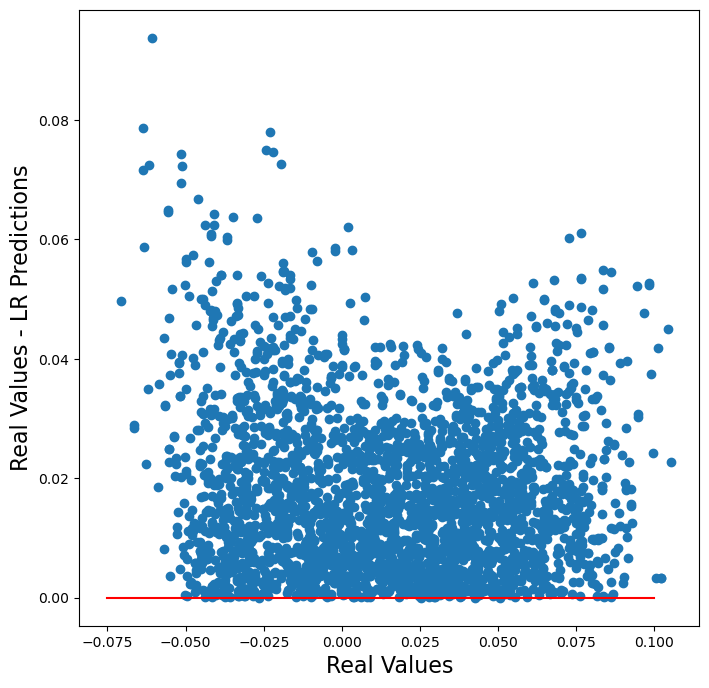

In [11]:
plt.figure(figsize = (8,8))
plt.scatter(y_test, np.abs(y_test-yhat))
plt.plot([-0.075,0.1], [0,0], c='r')
plt.ylabel('Real Values - LR Predictions', fontsize = 16)
plt.xlabel('Real Values', fontsize = 16)
plt.show()

The model has a tendency to make large errors when real values are small or large. 

Now we are going to do the same analysis using statsmodel package.

In [12]:
import statsmodels.api as sm
mod = sm.OLS(y_train, sm.add_constant(df_train, prepend=True))
results = mod.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   stab   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                     9487.
Date:                Fri, 07 Jul 2023   Prob (F-statistic):               0.00
Time:                        15:51:02   Log-Likelihood:             1.3680e+05
No. Observations:               57000   AIC:                        -2.736e+05
Df Residuals:                   56988   BIC:                        -2.735e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1438      0.001   -212.796      0.0

We can see that the multicollinearity for variables `p` causes the coefficients to be artificially large. We can also observe the same phenomenon with the scikit-learn model. 

In [13]:
coefficient = pd.DataFrame(lr.coef_, columns= df_train.columns)
print(coefficient.transpose())

                 0
tau1  3.613114e-03
tau2  3.689797e-03
tau3  3.832177e-03
tau4  3.727437e-03
p1   -2.017307e+11
p2   -2.017307e+11
p3   -2.017307e+11
p4   -2.017307e+11
g1    3.781200e-02
g2    3.923865e-02
g3    3.919310e-02
g4    3.916529e-02


## What can we say about the $p$ values of the variables? 
## What can we say about the coefficients?

You can choose to deal with multicollinearity. One of of doing this is removing the variables causing the multicollinearity, another approach can be using a method such as PCA to transform the data set and/or multicollinear features. However, we can see that the issue with the residuals is still here even when we drop a variable.

MAE:  0.0172408227540491
MSE:  0.0004766167024858453
MAPE:  3.515806257976602


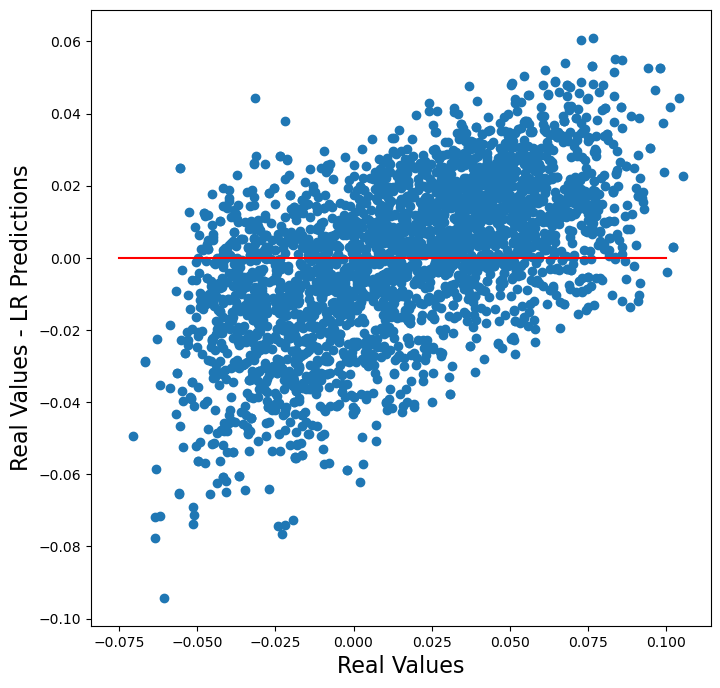

In [14]:
df_train_dropped = df_train.drop('p1', axis=1)
df_test_dropped = df_test.drop('p1', axis=1)

lr1 = LinearRegression(fit_intercept= True)

lr1.fit(df_train_dropped, y_train)

yhat = lr1.predict(df_test_dropped)


print('MAE: ', mean_absolute_error(y_test, yhat))
print('MSE: ',mean_squared_error(y_test, yhat))
print('MAPE: ',mean_absolute_percentage_error(y_test, yhat))

plt.figure(figsize = (8,8))
plt.scatter(y_test, y_test-yhat)
plt.plot([-0.075,0.1], [0,0], c='r')
plt.ylabel('Real Values - LR Predictions', fontsize = 16)
plt.xlabel('Real Values', fontsize = 16)
plt.show()


# Scaling and PCA Transformation

It is common to use scaling in linear/logistic regression as well as neural networks. In linear regression it helps with the optimization but does not actually increase the model accuracy.

MAE:  0.01724137392551263
MSE:  0.0004769042635057463
MAPE:  3.5672887162449465


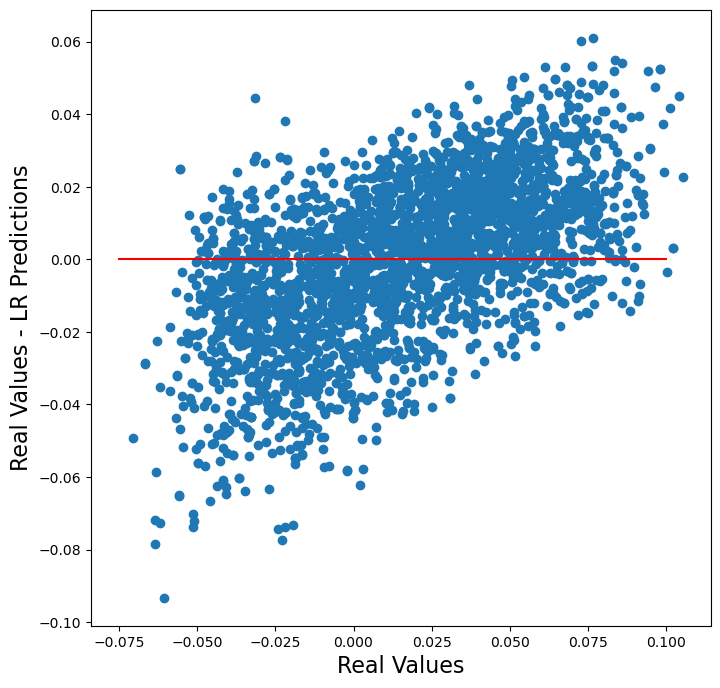

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
ssc = StandardScaler()

df_train = pd.DataFrame(ssc.fit_transform(df_train), columns= df_train.columns)
df_test = pd.DataFrame(ssc.transform(df_test), columns= df_train.columns)


lr = LinearRegression()

lr.fit(df_train, y_train)

yhat = lr.predict(df_test)

print('MAE: ', mean_absolute_error(y_test, yhat))
print('MSE: ',mean_squared_error(y_test, yhat))
print('MAPE: ',mean_absolute_percentage_error(y_test, yhat))


plt.figure(figsize = (8,8))
plt.scatter(y_test, y_test-yhat)
plt.plot([-0.075,0.1], [0,0], c='r')
plt.ylabel('Real Values - LR Predictions', fontsize = 16)
plt.xlabel('Real Values', fontsize = 16)
plt.show()

Another approach is using PCA transformation to get rid of the multicollinearity. PCA creates orthogonal vectors for transforming the data set, thus getting rid of the multicollinearity. However, in this case this also does not help with the results.

MAE:  0.01736316666749197
MSE:  0.0004819611497753365
MAPE:  3.4383483106457833


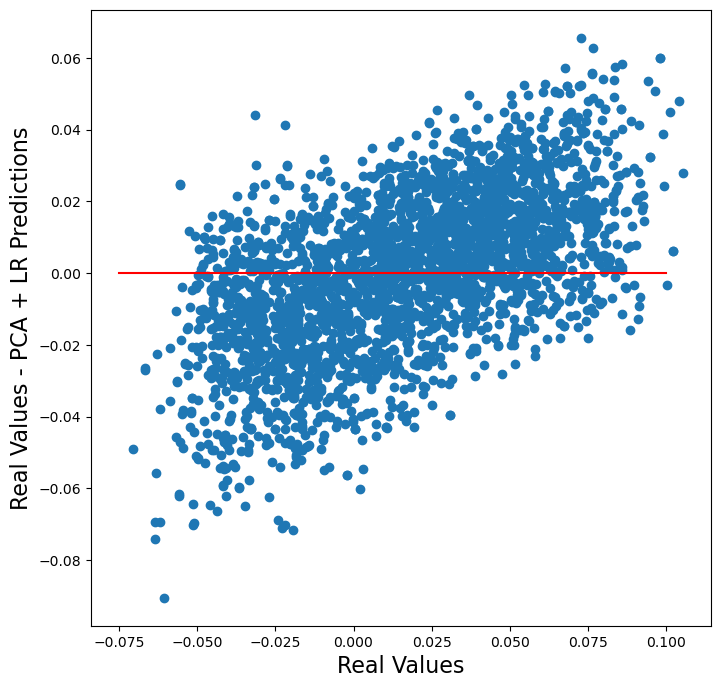

In [16]:
pca = PCA(n_components= 0.85)

df_train_pca = pca.fit_transform(df_train)
df_test_pca = pca.transform(df_test)

lr = LinearRegression()

lr.fit(df_train_pca, y_train)

yhat = lr.predict(df_test_pca)

print('MAE: ', mean_absolute_error(y_test, yhat))
print('MSE: ',mean_squared_error(y_test, yhat))
print('MAPE: ',mean_absolute_percentage_error(y_test, yhat))


plt.figure(figsize = (8,8))
plt.scatter(y_test, y_test-yhat)
plt.plot([-0.075,0.1], [0,0], c='r')
plt.ylabel('Real Values - PCA + LR Predictions', fontsize = 16)
plt.xlabel('Real Values', fontsize = 16)
plt.show()

<AxesSubplot:>

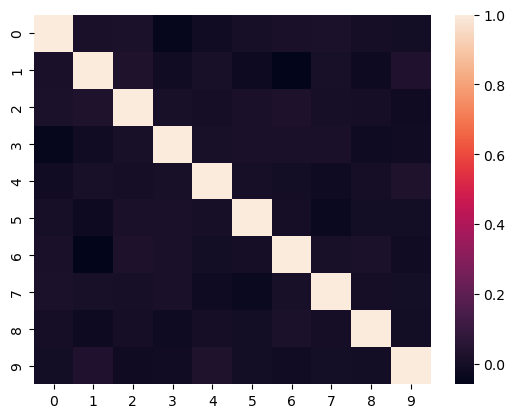

In [17]:
sns.heatmap(pd.DataFrame(df_test_pca).corr())

# Regularization

As we saw in the tables above, some features contribute to the label in very small amounts. It may be possible to drop some features by employing regularization. Regularization adds a penalty term to the objective function.

* In Ridge regression the penalty term is added as $\alpha \beta_{i}^{2}$
* In Lasso regression the penalty term is added as $\alpha |\beta_{i}|$. This allows for more variables to be set to 0 and also helps with feature reduction.
* Elastic Net is another approach that uses both types of penalties.

## How do we choose $\alpha$?

Let us start with Ridge regression, we select a wide range of alpha values and select the best one using cross validation.

In [18]:
from sklearn.linear_model import LassoCV, RidgeCV

ridge = RidgeCV(alphas=[1000,100,10,1,0.1,0.01,0.001, 0.0001, 0.00001, 0.000001])

ridge.fit(df_train, y_train)
yhat = ridge.predict(df_test)

print('The value of alpha: ', ridge.alpha_)

The value of alpha:  10.0


MAE:  0.017240938347307316
MSE:  0.00047661358008595206
MAPE:  3.5152367556107214


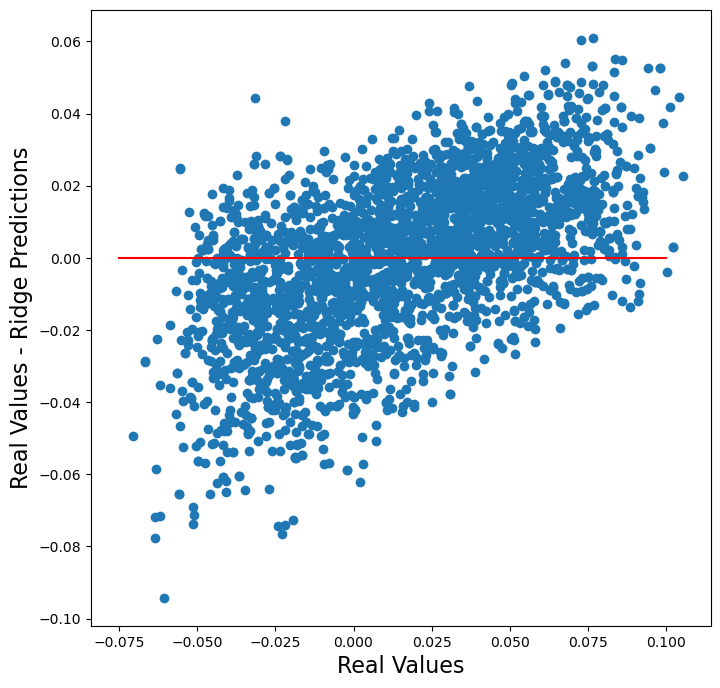

In [19]:
print('MAE: ', mean_absolute_error(y_test, yhat))
print('MSE: ',mean_squared_error(y_test, yhat))
print('MAPE: ',mean_absolute_percentage_error(y_test, yhat))

plt.figure(figsize = (8,8))
plt.scatter(y_test, y_test-yhat)
plt.plot([-0.075,0.1], [0,0], c='r')
plt.ylabel('Real Values - Ridge Predictions', fontsize = 16)
plt.xlabel('Real Values', fontsize = 16)
plt.show()

As you can see none of the variables are eliminated from the regression.

In [20]:
coefficient = pd.DataFrame(ridge.coef_.transpose(), index= df_train.columns)
print(coefficient)

             0
tau1  0.009895
tau2  0.010290
tau3  0.010307
tau4  0.010281
p1   -0.000008
p2    0.000005
p3    0.000016
p4   -0.000008
g1    0.010379
g2    0.010779
g3    0.010746
g4    0.010709


Lasso regression has a different penalty term considering the absolute value of the regression coefficients. This help us reduce the coefficient of some variables to 0.

We will try Lasso Regression using different penalty coefficients.

In [21]:
lasso = LassoCV(alphas=[10,1,0.1,0.01,0.001, 0.0001, 0.00001, 0.000001])

lasso.fit(df_train, y_train)
yhat = lasso.predict(df_test)

print('The value of alpha: ', lasso.alpha_)

The value of alpha:  1e-05


C:\Users\byuceoglu\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1571: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAE:  0.017241393158430866
MSE:  0.0004765895616843341
MAPE:  3.5124999852962397


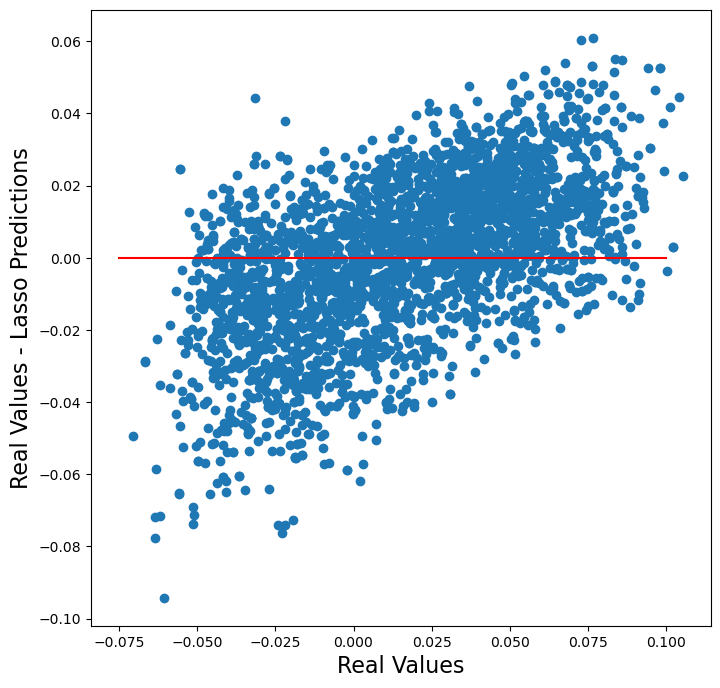

In [22]:
print('MAE: ', mean_absolute_error(y_test, yhat))
print('MSE: ',mean_squared_error(y_test, yhat))
print('MAPE: ',mean_absolute_percentage_error(y_test, yhat))

plt.figure(figsize = (8,8))
plt.scatter(y_test, y_test.values.reshape(1,-1)-yhat)
plt.plot([-0.075,0.1], [0,0], c='r')
plt.ylabel('Real Values - Lasso Predictions', fontsize = 16)
plt.xlabel('Real Values', fontsize = 16)
plt.show()

We can see that the variables `p3` and `p4` are eliminated from the model.

In [23]:
coefficient = pd.DataFrame(lasso.coef_, index= df_train.columns)
print(coefficient)

             0
tau1  0.009886
tau2  0.010281
tau3  0.010298
tau4  0.010272
p1   -0.000000
p2    0.000000
p3    0.000011
p4   -0.000000
g1    0.010371
g2    0.010771
g3    0.010738
g4    0.010701


We can study how the coefficients of linear regression change when we change the penalty coefficient.

       Alpha_1e-06  Alpha_1e-05  Alpha_0.0001  Alpha_0.001  Alpha_0.01  \
tau1  9.895404e-03     0.009886      0.009799     0.008922    0.000152   
tau2  1.029034e-02     0.010281      0.010193     0.009308    0.000463   
tau3  1.030735e-02     0.010298      0.010210     0.009323    0.000460   
tau4  1.028132e-02     0.010272      0.010184     0.009298    0.000437   
p1   -1.426570e-05    -0.000000     -0.000000     0.000000    0.000000   
p2    5.473436e-07     0.000000      0.000000    -0.000000   -0.000000   
p3    1.181850e-05     0.000011      0.000000     0.000000   -0.000000   
p4   -1.075582e-05    -0.000000     -0.000000    -0.000000   -0.000000   
g1    1.038007e-02     0.010371      0.010282     0.009390    0.000470   
g2    1.078023e-02     0.010771      0.010682     0.009792    0.000885   
g3    1.074706e-02     0.010738      0.010649     0.009759    0.000860   
g4    1.071031e-02     0.010701      0.010612     0.009722    0.000816   

      Alpha_0.1  Alpha_1  Alpha_10  


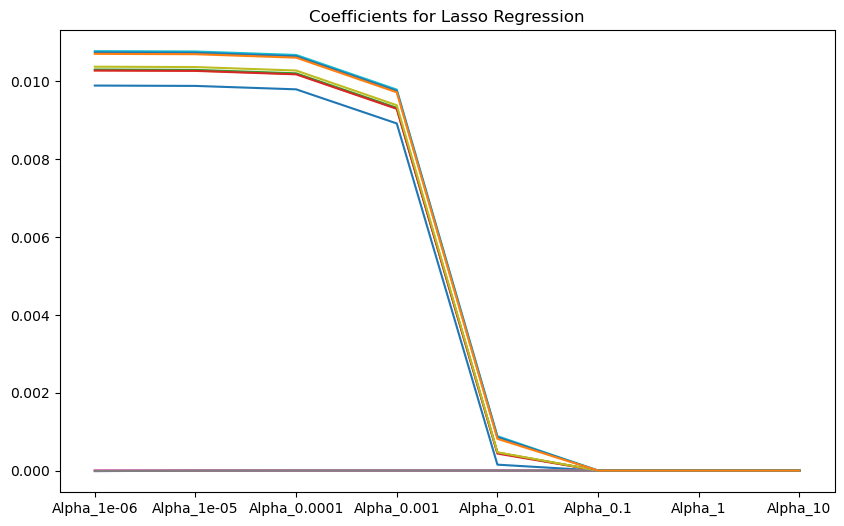

In [24]:
from sklearn.linear_model import Lasso

coefficients = pd.DataFrame(index = df_train.columns)

alphas =  [10,1,0.1,0.01,0.001, 0.0001, 0.00001, 0.000001]
alphas.reverse()

for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(df_train,y_train)
    coefficient = pd.DataFrame(lasso.coef_, index= df_train.columns, columns= ['Alpha_'+str(alpha)])
    coefficients = pd.concat([coefficients,coefficient], axis=1)

print(coefficients)

plt.figure(figsize = (10,6))
plt.title('Coefficients for Lasso Regression')
plt.plot(coefficients.transpose())

In Ridge regression, the coefficients go to 0 more slowly.

      Alpha_0.001  Alpha_0.01  Alpha_0.1   Alpha_1  Alpha_10  Alpha_100  \
tau1     0.009896    0.009896   0.009896  0.009896  0.009895   0.009880   
tau2     0.010291    0.010291   0.010291  0.010291  0.010290   0.010274   
tau3     0.010308    0.010308   0.010308  0.010308  0.010307   0.010291   
tau4     0.010282    0.010282   0.010282  0.010282  0.010281   0.010265   
p1      -0.000008   -0.000008  -0.000008 -0.000008 -0.000008  -0.000008   
p2       0.000005    0.000005   0.000005  0.000005  0.000005   0.000005   
p3       0.000017    0.000017   0.000017  0.000017  0.000016   0.000016   
p4      -0.000008   -0.000008  -0.000008 -0.000008 -0.000008  -0.000008   
g1       0.010381    0.010381   0.010381  0.010381  0.010379   0.010363   
g2       0.010781    0.010781   0.010781  0.010781  0.010779   0.010763   
g3       0.010748    0.010748   0.010748  0.010748  0.010746   0.010729   
g4       0.010711    0.010711   0.010711  0.010711  0.010709   0.010693   

      Alpha_1000  Alpha_

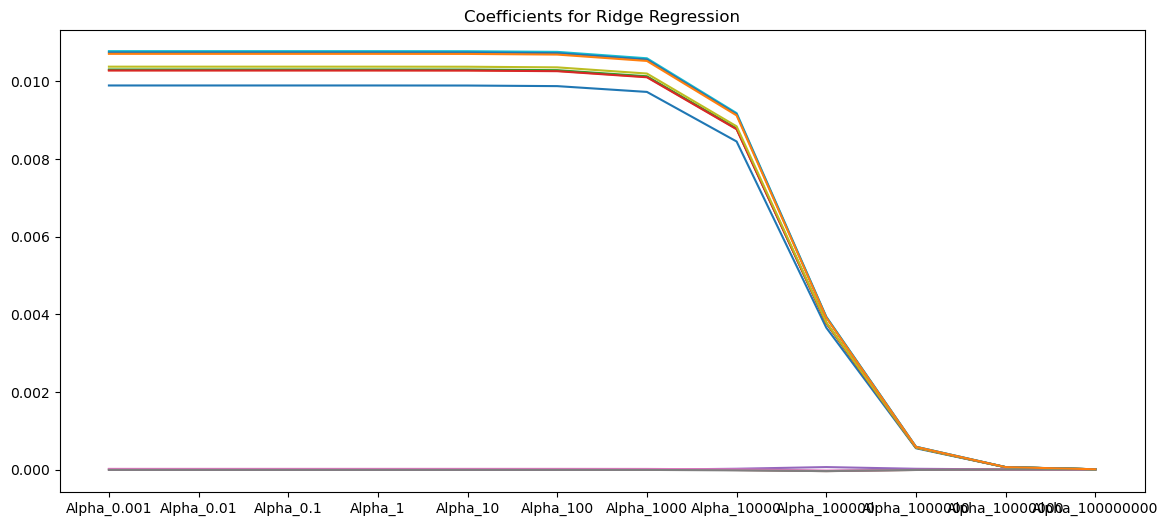

In [25]:
from sklearn.linear_model import Ridge

coefficients = pd.DataFrame(index = df_train.columns)

alphas =  [100000000,10000000,1000000, 100000,10000,1000,100,10,1,0.1,0.01,0.001]
alphas.reverse()

for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(df_train,y_train)
    coefficient = pd.DataFrame(ridge.coef_.transpose(), index= df_train.columns, columns= ['Alpha_'+str(alpha)])
    coefficients = pd.concat([coefficients,coefficient], axis=1)

print(coefficients)

plt.figure(figsize = (14,6))
plt.title('Coefficients for Ridge Regression')
plt.plot(coefficients.transpose())


# Neural Networks

We can also use tensorflow to create a regression model. We need to use linear activation at the end instead of the sigmoid funtion as we do not deal with probabilities but with continuous numbers. We can also use Relu if the label does not go below 0.

We are going to create a large network consisting of 128 hidden units in two layers. This allows us to catch nonlinear patterns.


In [26]:
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout

model = Sequential()
model.add(Dense(128, input_dim = df_train.shape[1],activation= 'relu'))
model.add(Dense(128,activation= 'relu'))
model.add(Dense(1, activation= 'linear'))

model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error')

In [27]:
history = model.fit(
    df_train,
    y_train,
    epochs=150,
    batch_size = 128,
    # Suppress logging.
    verbose=2,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2,
    shuffle = True)

Epoch 1/150
357/357 - 2s - loss: 0.0018 - val_loss: 5.5380e-04 - 2s/epoch - 5ms/step
Epoch 2/150
357/357 - 1s - loss: 3.8650e-04 - val_loss: 3.2501e-04 - 713ms/epoch - 2ms/step
Epoch 3/150
357/357 - 1s - loss: 2.4859e-04 - val_loss: 2.2000e-04 - 750ms/epoch - 2ms/step
Epoch 4/150
357/357 - 2s - loss: 1.8222e-04 - val_loss: 1.8265e-04 - 2s/epoch - 5ms/step
Epoch 5/150
357/357 - 2s - loss: 1.4830e-04 - val_loss: 1.4281e-04 - 2s/epoch - 5ms/step
Epoch 6/150
357/357 - 1s - loss: 1.2317e-04 - val_loss: 1.2326e-04 - 813ms/epoch - 2ms/step
Epoch 7/150
357/357 - 1s - loss: 1.0870e-04 - val_loss: 1.1047e-04 - 998ms/epoch - 3ms/step
Epoch 8/150
357/357 - 1s - loss: 9.8154e-05 - val_loss: 1.0141e-04 - 919ms/epoch - 3ms/step
Epoch 9/150
357/357 - 1s - loss: 8.3138e-05 - val_loss: 8.9508e-05 - 1s/epoch - 3ms/step
Epoch 10/150
357/357 - 1s - loss: 7.9223e-05 - val_loss: 8.9877e-05 - 713ms/epoch - 2ms/step
Epoch 11/150
357/357 - 2s - loss: 7.2380e-05 - val_loss: 8.5105e-05 - 2s/epoch - 5ms/step
Epoch

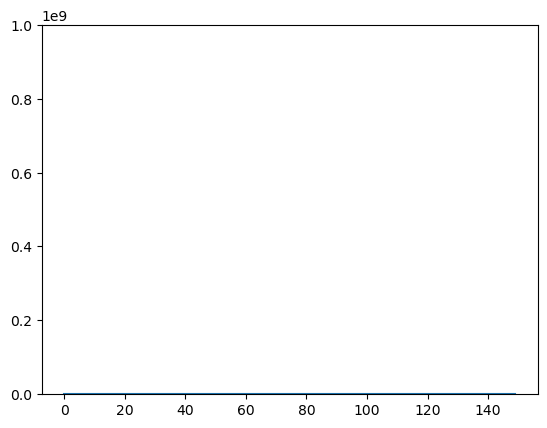

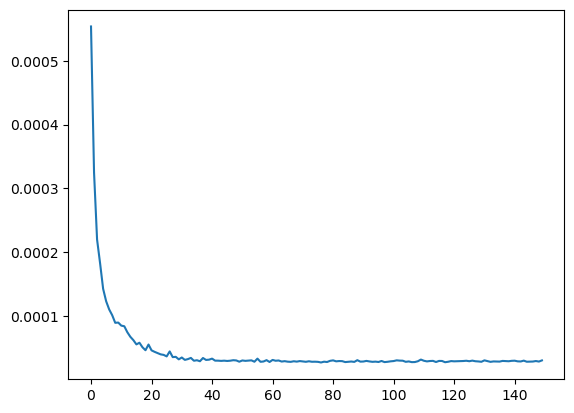

In [28]:
plt.plot(history.history['loss'])
plt.ylim((0,1e9))
plt.show()
plt.plot(history.history['val_loss'])

94/94 [==============================] - 0s 3ms/step
MAE:  0.0035154148404968246
MSE:  3.2705146695017305e-05
MAPE:  0.342390219362342


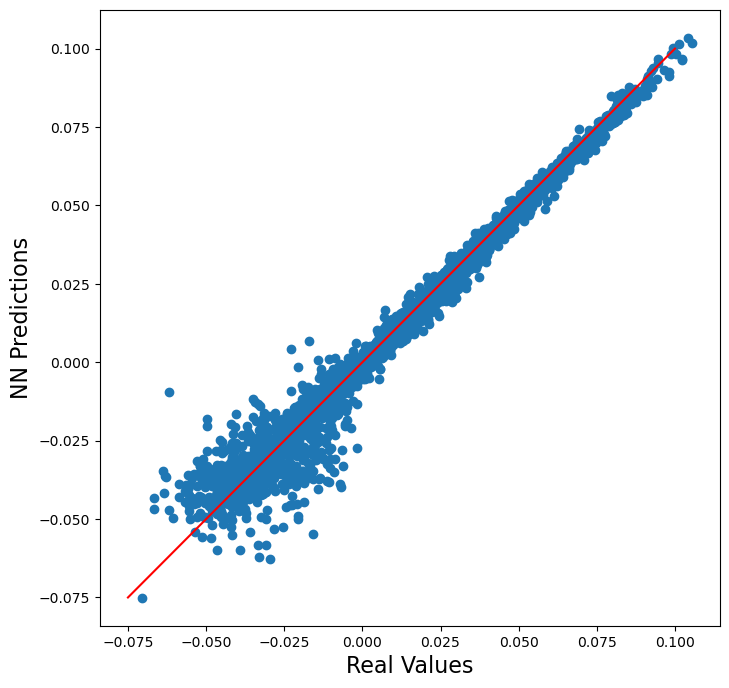

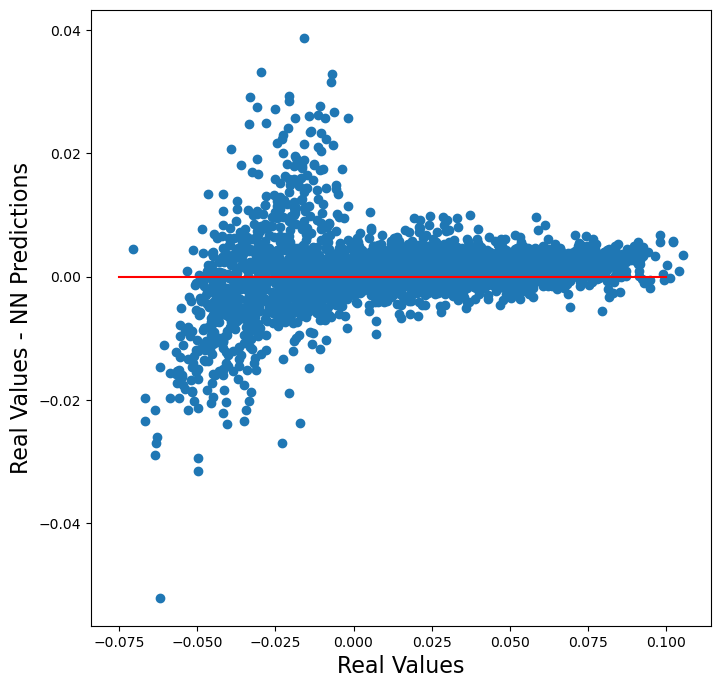

In [29]:
yhat = model.predict(df_test)

print('MAE: ', mean_absolute_error(y_test, yhat))
print('MSE: ',mean_squared_error(y_test, yhat))
print('MAPE: ',mean_absolute_percentage_error(y_test, yhat))

plt.figure(figsize = (8,8))
plt.scatter(y_test, yhat)
plt.plot([-0.075,0.1], [-0.075,0.1], c='r')
plt.ylabel('NN Predictions', fontsize = 16)
plt.xlabel('Real Values', fontsize = 16)
plt.show()

plt.figure(figsize = (8,8))
plt.scatter(y_test, y_test-yhat)
plt.plot([-0.075,0.1], [0,0], c='r')
plt.ylabel('Real Values - NN Predictions', fontsize = 16)
plt.xlabel('Real Values', fontsize = 16)
plt.show()

# Using Polynomial Features

So far apart from the neural networks, all the methods we tried are linear models. It means that if a variable has a nonlinear relationship with the label, this relation is not considered. A way to add nonlinear relationship is to add polynomial features to the data set. These features will contain terms like $x_1^2$ or $x_1 x_2$ called interaction terms. Using such an approach creates a large number of features. Therefore it is advisable to use it with a feature elimination framework. We are going to use Lasso Regression to eliminate features.

In [30]:
from sklearn.preprocessing import PolynomialFeatures

pf = PolynomialFeatures(degree=2, interaction_only=False)

df_train_transformed = pf.fit_transform(df_train)
df_test_transformed = pf.transform(df_test)

C:\Users\byuceoglu\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1571: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.001
MAE:  0.010573381994139241
MSE:  0.00018559003704859457
MAPE:  2.2690123973637992


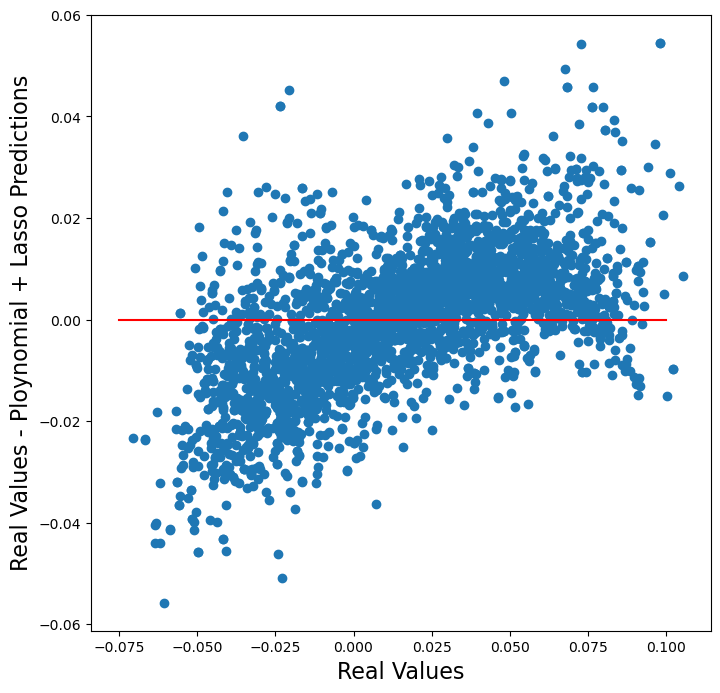

In [31]:
lasso = LassoCV(alphas = [.001, .01, .1, 1])
lasso.fit(df_train_transformed, y_train)

yhat = lasso.predict(df_test_transformed)
print(lasso.alpha_)

print('MAE: ', mean_absolute_error(y_test, yhat))
print('MSE: ',mean_squared_error(y_test, yhat))
print('MAPE: ',mean_absolute_percentage_error(y_test, yhat))


plt.figure(figsize = (8,8))
plt.scatter(y_test, y_test.values.reshape(1,-1)-yhat)
plt.plot([-0.075,0.1], [0,0], c='r')
plt.ylabel('Real Values - Ploynomial + Lasso Predictions', fontsize = 16)
plt.xlabel('Real Values', fontsize = 16)
plt.show()

In [32]:
import numpy as np
coefficient = pd.DataFrame(lasso.coef_, index= pf.get_feature_names_out(), columns=['Coefficient'])
coefficient['abs'] = np.abs(coefficient['Coefficient'])
coefficient = coefficient.sort_values('abs', ascending= False)
print(coefficient.head(35))

           Coefficient       abs
g2            0.009787  0.009787
g3            0.009763  0.009763
g4            0.009733  0.009733
g1            0.009643  0.009643
tau3          0.009363  0.009363
tau4          0.009341  0.009341
tau2          0.009325  0.009325
tau1          0.009062  0.009062
tau1^2       -0.006371  0.006371
tau3^2       -0.006286  0.006286
tau2^2       -0.006279  0.006279
tau4^2       -0.006272  0.006272
tau4 g4       0.004238  0.004238
tau3 g3       0.004236  0.004236
tau2 g2       0.004216  0.004216
tau1 g1       0.004085  0.004085
tau1 tau2     0.001009  0.001009
tau1 tau4     0.000990  0.000990
tau1 tau3     0.000976  0.000976
tau2 tau3     0.000860  0.000860
tau2 tau4     0.000854  0.000854
tau3 tau4     0.000850  0.000850
tau4 g1      -0.000124  0.000124
tau2 g1      -0.000092  0.000092
tau3 g1      -0.000090  0.000090
tau4 g2      -0.000062  0.000062
tau3 g4      -0.000030  0.000030
tau2 g4      -0.000028  0.000028
tau2 g3      -0.000027  0.000027
tau3 g2   

# Reducing Bias (Finally!!)

We already learned that ensemble approaches aim to reduce the bias. We will now employ the gradient boosting algorithm to reduce the bias.

We create a lightgbm model as a regressor. 

Let us explore the `num_iterations` and `learning_rate` parameters.

In [33]:
import lightgbm as lgb

gbr = lgb.LGBMRegressor(num_leaves = 63, objective = 'regression_l2', num_iterations = 200, learning_rate = 0.1)

gbr.fit(df_train,y_train)

C:\Users\byuceoglu\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


LGBMRegressor(num_iterations=200, num_leaves=63, objective='regression_l2')

MAE:  0.004208379242741963
MSE:  3.1740518459459424e-05
MAPE:  1.1654117598785314


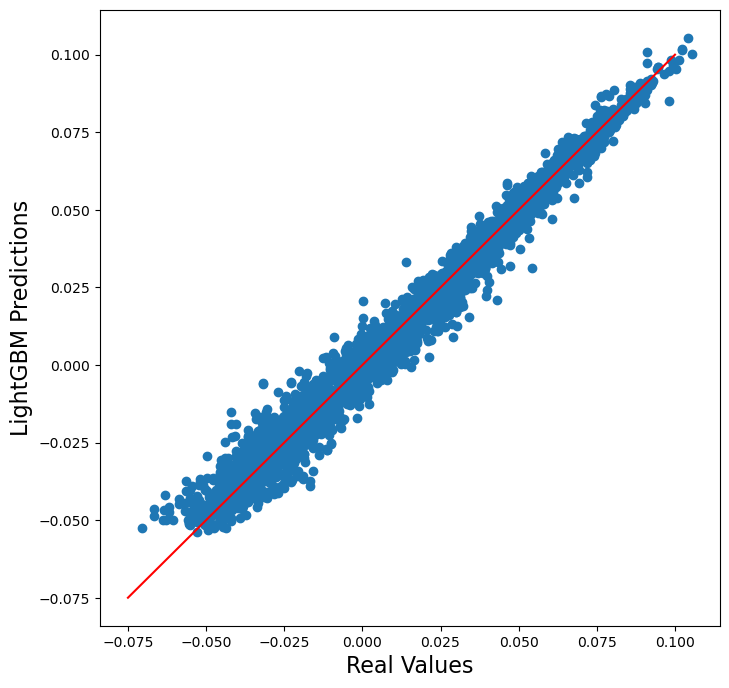

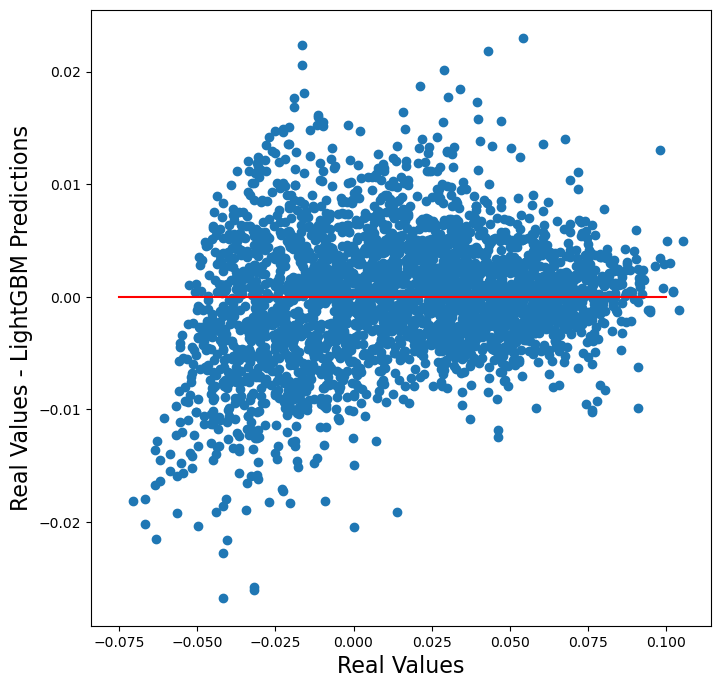

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

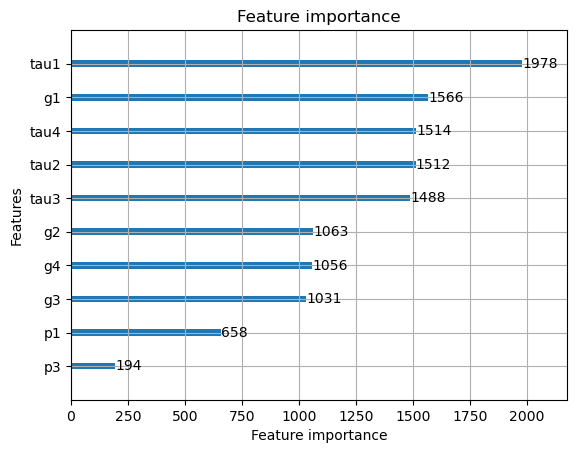

In [34]:
yhat = gbr.predict(df_test)

print('MAE: ', mean_absolute_error(y_test, yhat))
print('MSE: ',mean_squared_error(y_test, yhat))
print('MAPE: ',mean_absolute_percentage_error(y_test, yhat))

plt.figure(figsize = (8,8))
plt.scatter(y_test, yhat)
plt.plot([-0.075,0.1], [-0.075,0.1], c='r')
plt.ylabel('LightGBM Predictions', fontsize = 16)
plt.xlabel('Real Values', fontsize = 16)
plt.show()

plt.figure(figsize = (8,8))
plt.scatter(y_test, y_test.values.reshape(1,-1)-yhat)
plt.plot([-0.075,0.1], [0,0], c='r')
plt.ylabel('Real Values - LightGBM Predictions', fontsize = 16)
plt.xlabel('Real Values', fontsize = 16)
plt.show()

lgb.plot_importance(gbr, max_num_features=10)

We manged to reduce the performance metrics as follows and manged to create an unbiased model:

* MAE:  0.016840113301859576  -->  0.002994764457290073
* MSE:  0.0004525558526912025  -->  1.578490790065813e-05
* MAPE:  4.10784611123188  -->  0.4581822813149555